## MODEL 
* Install muna ako NVIDIA CUDA tas cuDNN para di sumabog PC 

In [7]:
import os
import time
import numpy as np
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

In [8]:
def extract_colors(image, k=6):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab_image.reshape((-1, 3))
    
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pixels)
    
    dominant_colors = kmeans.cluster_centers_.flatten()  # Flatten colors for MLP input
    return dominant_colors

def load_images_and_labels(folder, label, k=6):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(image_path, color_mode="rgb"))
        image = image.astype(np.uint8)
        color_features = extract_colors(image, k=k)
        images.append(color_features.reshape(1, -1))

    labels = [label] * len(images)
    return np.vstack(images), np.array(labels)

In [9]:
train_jaundiced_images, train_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class/train", 1)
train_healthy_images, train_healthy_labels = load_images_and_labels("./new/Normal Class/train", 0)

X_train = np.vstack((train_jaundiced_images, train_healthy_images))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))
X_train, y_train = shuffle(X_train, y_train, random_state=1)

test_jaundiced_images, test_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class/test", 1)
test_healthy_images, test_healthy_labels = load_images_and_labels("./new/Normal Class/test", 0)

X_test = np.vstack((test_jaundiced_images, test_healthy_images))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))

val_jaundiced_images, val_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class/validate", 1)
val_healthy_images, val_healthy_labels = load_images_and_labels("./new/Normal Class/validate", 0)

X_val = np.vstack((val_jaundiced_images, val_healthy_images))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))

print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Jaundiced images shape:", train_jaundiced_images.shape)
print("Healthy images shape:", train_healthy_images.shape)
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("First 5 rows of X_train:", X_train[:5])

Test data shape: (120, 18)
Validation data shape: (245, 18)
Jaundiced images shape: (390, 18)
Healthy images shape: (457, 18)
X_train shape: (847, 18)
X_train dtype: float64
First 5 rows of X_train: [[132.62834225 130.50687548 115.22727273  68.53681247 135.87072326
  104.13869641  21.06140677 125.26051358 129.183476    20.45527015
  140.5640685  100.95969885 101.11602465 133.89676425 108.12357473
   43.7766524  136.69207476 103.64404302]
 [194.0103184  128.00943396 102.4348467  103.98964032 136.44406937
   91.10848562   3.20638003 128.67489598 126.20970874 169.33249189
  134.21628201  90.85007212  68.04728423 135.20741782  97.31833363
  141.36024112 135.82387629  88.8707902 ]
 [ 73.77862595 133.17951654 105.8480916  160.37713277 131.55834477
  100.86036478  37.04763682 129.80995025 120.44676617 118.40315638
  132.76024231 101.58249641 201.80888122 129.87870705 102.63502275
   10.68025177 127.89346971 125.58630999]
 [ 86.98365173 130.13592946 107.43681117 174.53054522 128.98981826
  109

In [10]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (847, 18)
X_test shape: (120, 18)
X_val shape: (245, 18)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit 
X_test = scaler.transform(X_test)       # Transform test data (images only with no annotations but with features)
X_val = scaler.transform(X_val)

In [12]:
model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),  
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\kenji\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs= 100,
    batch_size= 64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

elapsed_time = time.time() - start_time

# Evaluate Model
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
stopped_epoch = early_stopping.stopped_epoch

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}")
print(f"Training stopped at Epoch: {stopped_epoch}, Time Taken: {elapsed_time:.2f} sec")


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9820 - loss: 0.2315 - precision_7: 0.9850 - recall_7: 0.9759 - val_accuracy: 0.8571 - val_loss: 0.6479 - val_precision_7: 0.8611 - val_recall_7: 0.8230 - learning_rate: 5.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9628 - loss: 0.2456 - precision_7: 0.9393 - recall_7: 0.9748 - val_accuracy: 0.8449 - val_loss: 0.6662 - val_precision_7: 0.8571 - val_recall_7: 0.7965 - learning_rate: 5.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9804 - loss: 0.2248 - precision_7: 0.9808 - recall_7: 0.9766 - val_accuracy: 0.8612 - val_loss: 0.6314 - val_precision_7: 0.8559 - val_recall_7: 0.8407 - learning_rate: 5.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9880 - loss: 0.2087 - precision_7: 0.9815 - recall_7: 0.9935 - val_accuracy: 0.8694 - val_loss: 0.6092 - val_precision_7: 0.8857 - val_recall_7: 0.8230 - learning_rate: 5.0000e-04
Epoch 5/100
14/14 ━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87        65
           1       0.83      0.89      0.86        55

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120



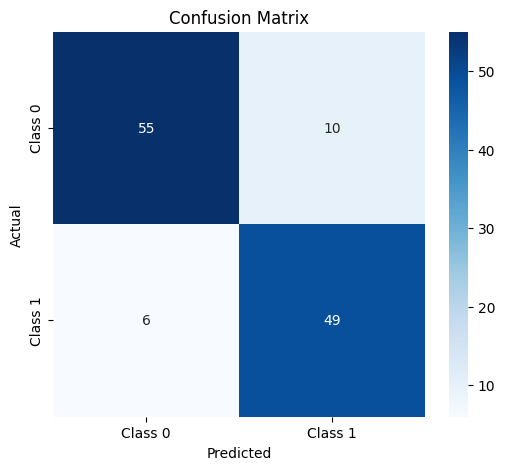

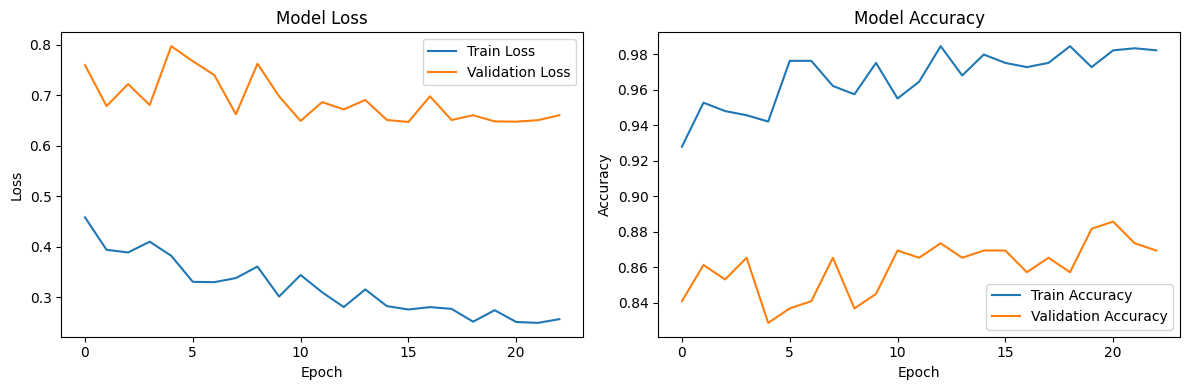

In [17]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Loss and Accuracy Plots
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
